# 04-04-2023
### De data verbergen
De data moet alleen voor studenten beschikbaar zijn tijdens het project. Daarna moet iedereen de data weer weggooien. Met onderstaande code kunnen we ervoor zorgen dat de data nooit naar de studenten gestuurd hoeft te worden, maar dat ze deze direct vanaf een server in hun notebook laden. Elke keer als ze hun notebook sluiten is de data weer weg, en we kunnen hun de toegang ontzeggen door hun inlogaccount in te trekken. 

De onderstaande code doet dit via een SFTP verbinding. Voor elke databron moet je een toegangsfunctie schrijven die een pandas dataframe uitspuugt. Dat is waar de studenten mee aan de slag gaan. 

In [ ]:
from data_loading_functions import get_psma_file

df = get_psma_file('s123456', 'xxxxxxx')
df

### Ook de code verbergen
In de functie die de studenten toegang geeft tot de data staat ook details over de data. Bijvoorbeeld wat het password is om toegang tot de excel file te krijgen. Door ook de toegangsfuncties vanaf de SFTP server te lezen creeeren we weer een laag van veiligheid om de data heen. **Het uitgangspunt is dat de happy flow zo vleilig mogelijk is**. Als extraatje kunnen we op deze manier ook de code die nodig is om de data in te lezen updaten. 

De code hieronder lees de source file vanaf de SFTP server en geeft dit terug als een library achtig object. Daarna kun je de specifieke laad functie voor de data gebruiken die de daadwerkelijke data van de SFTP server haalt. 

In [ ]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('files/data.csv', 's123456', 'xxxxxxx')
data_loading_module.get_psma_file('s123456', 'xxxxxxx')

# Inlezen van de PSMA excel file
We gaan de loader functie maken voor de PSMA Excel file:

In [ ]:
import msoffcrypto
import io
import pandas as pd

excel_file = "data.xlsm"

def psma_loader(fname):
    decrypted = io.BytesIO()
    with open(fname, "rb") as f:
        file = msoffcrypto.OfficeFile(f)
        file.load_key(password="xxxxxxx")  # Use password
        file.decrypt(decrypted)

        return pd.read_excel(decrypted, sheet_name='Data', nrows=60, skiprows=1)

df = psma_loader(excel_file)
df.tail(1)

Dit laat zien dat de loader functie werkt. Van belang:
- We lezen alleen de eerste 60 rijen, hierna komen wat samenvattingen van de bovenliggende data en een stuk van de data die niet compleet is. Deze laatste twee stukken slaan we dus over. 
- We slaan de eerste rij over, de tweede rij bevat de kolomnamen. 

# 05-04-2023
### Verkennen van de data
De data bevat de volgende kolommen:

In [ ]:
df.columns

Wat me hier opvalt is dat er kolommen zijn die niet in de Excel staan (vanaf `Lymf_1_or_inguinale0`). Dit komt doordat de kolommen daarna op verborgen staan. Ik heb Joris al even gevraagd wat ik hier mee moet doen. 

In [ ]:
df.info()

De eerste kolom `Onderzoeksnummer (Patientx)` is het patientnummer, een unieke waarde voor elk van de 60 patienten die in deze dataset zitten. De volgende kolommen (`Gewicht` tot `Leeftijd_scan`) geven een aantal eigenschappen van de 

# 06-04-2023

### TODO
- put the username and password in a config file: https://dev.to/jakewitcher/using-env-files-for-environment-variables-in-python-applications-55a1
- stop de hostname ook in de config file
- maak een test scripts
    - bash script
    - kijkt of je met de test account die actief is iets kan inlezen waar je *wel* bij mag
    - en kijkt of je ergens niet bij kan waar je ook geen toegang toe hebt

### Instellingen in een config file stoppen
Nu staan de username en password expliciet in de code, maar een meer veilige aanpak is om dit in een los config bestandje te stoppen. Hier kan dan direct alle configuratie spul zijn plaats vinden, inclusief de hostname. Naast veiligheid (password staat nu in de code die het repo in gaat) is het ook handig voor overdracht naar de studenten: je geeft ze een config bestandje met alle relevante settings. Dit, gecombineerd met de code om de leeslibrary in te laden van de SFTP server, zorgt ervoor dat ze de data kunnen lezen. 

Gido kwam met de suggestie om Environment variables hiervoor in te zetten, hij stuurde ook een [link met de beschrijving](https://dev.to/jakewitcher/using-env-files-for-environment-variables-in-python-applications-55a1). Dit is een mooie cleane oplossing, met als enige nadeel dat je een extra package moet installeren. 

Wat ontwerpbeslissingen rondom deze config file setup:
- Ik wil dat de de aanwezigheid van de conf file verplicht is. Als deze niet gevonden wordt geven we geen defaults. We moeten we een goede foutmelding geven zodat studenten weten wat er aan de hand is. 

# 12-04-2023
### Issue met de jupyter server op de verkeerde poort
Na een VS Code update startte de Jupyter server op poort 8889 op ipv 8888. Na wat klooien blijkt dat je in de docker file niet langer port forwarding hoeft te doen. Sterker nog, als je het doet dan fiets je tegen het opstarten van Jupyter server in. 

### Aan de slag met de SFTP server
Gido heeft de SFTP server nu ingesteld. Er is per groepje een directory beschikbaar waar hun eigen data klaar gaat staan. Verder is er ook nog eens scripts directory waar de code klaar staat om ingelezen te worden. 

Als eerste stap gaan we de code klaar zetten en kijken of we die vanaf de server kunnen laden. Eerste kopieren we de code naar de home dir van mijn account:

    > scp data_loading_functions.py vicodin:~

we kunnen niet direct naar `/var/sftp` kopieren aangezien mijn normale account niet direct sudo rechten heeft. Volgende stap is het kopieren naar de sftp directory en de rechten goed zetten:

    vicodin> sudo cp data_loading_functions.py /var/sftp/scripts/
    vicodin> cd /var/sftp/scripts/
    vicodin> sudo chown root:students data_loading_functions.py

Nu kunnen we gaan kijken of we deze code ingelezen krijgen: 

In [5]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py')
#data_loading_module.get_psma_file('s123456', 'xxxxxxx')

/tmp/tmpcs7kre3p


AttributeError: 'NoneType' object has no attribute 'loader'

Hieronder repliceer ik een deel van de code om erachter te komen wat er aan de hand is. 

In [ ]:
import paramiko
from dotenv import load_dotenv
import tempfile
import os
import subprocess
import importlib.util
from pathlib import Path

load_dotenv()
HOSTNAME = os.getenv("SFTP_HOSTNAME")
USERNAME = os.getenv("SFTP_USERNAME")
PASSWORD = os.getenv("SFTP_PASSWORD")
print(HOSTNAME, USERNAME, PASSWORD)
fname = 'scripts/data_loading_functions.py'

with open("tmp_loading_file.py", "wb") as tmp:
    with paramiko.SSHClient() as ssh_client:
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(hostname=HOSTNAME, username=USERNAME, password=PASSWORD, allow_agent=False)
        sftp_client = ssh_client.open_sftp()
        with ssh_client.open_sftp() as sftp_client:
            with sftp_client.open(fname) as f:
                tmp.write(f.read())

spec = importlib.util.spec_from_file_location("Loading data functions", "tmp_loading_file.py")
Path('tmp_loading_file.py').unlink()

print(spec)

Na wat klooien werkt de code hierboven. Het issue is dat de temp file op mijn PC aangemaakt wordt en dus niet in de container toegankelijk is. Dan maar hard een naam kiezen (en hopen dat de student niet precies dezelfde kies) en handmatig weggooien. 

# 13-03-2023
Na wat testen bleek de bovenstaande oplossing ook niet goed te werken. Uiteindelijk na een goed gesprek met ChatGPT was de beste oplossing uiteindelijk om `dir = "."` mee te geven aan `tempfile.NamedTemporaryFile`. Dit zorgde ervoor dat het bestand beschibaar was in de huidige directory, en lost alle problemen op met deleten van bestanden, voorkomen dat het bestand al bestaat, etc. Dit maakt de code veel simpeler. 

Checken of het werkt:

In [ ]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py')

Eerste leidde dit onverwacht niet tot de foutmelding die ik dacht (op de server is een syntax error). Het issue hier was dat ik verwachten was om `tmp_file.flush()` toe te voegen. Dit om te foceren dat de content van `tmp_file.write()` ook daadwerkelijk naar de disk gaat. 

Volgende stap is om de `data_loading_functions.py` file helemaal up-te-daten:
- Juiste filenaam
- Gebruik maken van credentails in de .env file

Ik heb nu ook de functie `get_vicodin_module` uitgebreid met een local_file optie, kun je eerste je code testen op lokale file. Als alles dan werkt kun je deze uploaden naar de sftp server:

In [2]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py', local_file="data_loading_functions.py")
data_loading_module.get_psma_file()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd0 in position 0: invalid continuation byte

The next problem is that we cannot decode the encrypted excel file using `io.StringIO(f.read().decode())`, which yields the above error. The solution is to keep the binary data in an `io.BytesIO` buffer, never decoding the stuff until it is actually needed. 

In [ ]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py', local_file="data_loading_functions.py")
data_loading_module.get_psma_file().head(1)

Volgende stap is om te testen of dit ook voor andere files werkt, bv een test csv bestandje:

In [4]:
import pandas as pd

pd.read_csv('test.csv')

,kolom_a,kolom_b
0,1,2
1,3,4
2,5,6


In [2]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py', local_file="data_loading_functions.py")
data_loading_module.get_test_file()

,kolom_a,kolom_b
0,1,2
1,3,4
2,5,6


Which confirms that the code works on the local copy of `data_loading_functions.py`. After copying the latest version to the sftp server we can test:

In [ ]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py')
data_loading_module.get_test_file()

In [ ]:
data_loading_module.get_psma_file().head(1)

Both work as advertised. Nice. 

# 17-04-2023: requirements
Het systeem wat we nu gebouwd hebben is natuurlijk alleen nuttig als het ook voldoet aan de requirements. Deze requirements zitten impliciet wel in dit labbook, maar voor het opstellen van de tests is het goed om dit wat meer te structureren. Het systeem ziet er nu als volgt uit:

![img](pics/flowchart_dataloading.png)

Een jupyter notebook doet een verzoek naar de SFTP server voor de code die nodig is om de data in te lezen. Als er een valide SFTP account is, dan krijgt de student de data. De data lees software is opgeslagen in een `scripts` directory op de SFTP server die toegankelijk is voor alle studenten. 

Vervolgens kan de data-lees code gebruikt worden om daadwerkelijk de data binnen te halen. Per databron is er een custom laad functie beschikbaar die de data ophaalt en naar een dataframe omzet. Welke databestanden beschikbaar zijn wordt bepaald door de account die je opgeeft. Bijvoorbeeld, alleen als je een psma account hebt staat deze data ook voor je beschikbaar. Als je de functie `get_psma_data` aanroept zonder een valide account krijg je een foutmelding omdat je een niet bestaand (voor jou niet bestaand) databestand probeert op te halen. 

De happy flow bevat de volgende requirements:
**Er is eigenlijk maar 1 usecase/user story "als student wil ik data downloaden", wellicht ook "als docent wil ik data beschikbaar stellen"
- UC1: Als student wil ik data beschikbaar hebben zodat ik mijn onderzoek kan uitvoeren. 
    - AC: de student moet *niet* data kunnen downloaden waar geen toestemming voor is
    - AC: De student krijgt de data terug in een Pandas DataFrame. Andere details zoals passwords voor Excel files moeten niet zichtbaar zijn voor studenten. 
    - AC: de data wordt *niet* op de hard schijf van de studenten opgeslagen, zodra de Jupyter Kernel afgesloten wordt moet de data weg zijn
    - AC: de student moet met de data kunnen werken zonder een netwerkverbinding, alleen bij het inladen is netwerk nodig
    - AC: de student moet de data kunnen inladen vanaf elke plek met een netwerk verbinding, niet alleen vanuit WH of Isala bv. 
    - AC: de credentials voor de SFTP server moeten los staan van deze source code

# 21-04-2023
De groep gaf aan dat er een permissionprobleem was met de temp file. Het lag aan dit ding: https://stackoverflow.com/a/23212515/1033808. 

De oplossing was om de file handmatig lokaal in te laden, dit had niet last van de permission bug. 

# 25-04-2023
Ik heb net voor het xxxxxx project een heel gesprek met xxxxx gehad.

Dit zijn de aantekeningen:
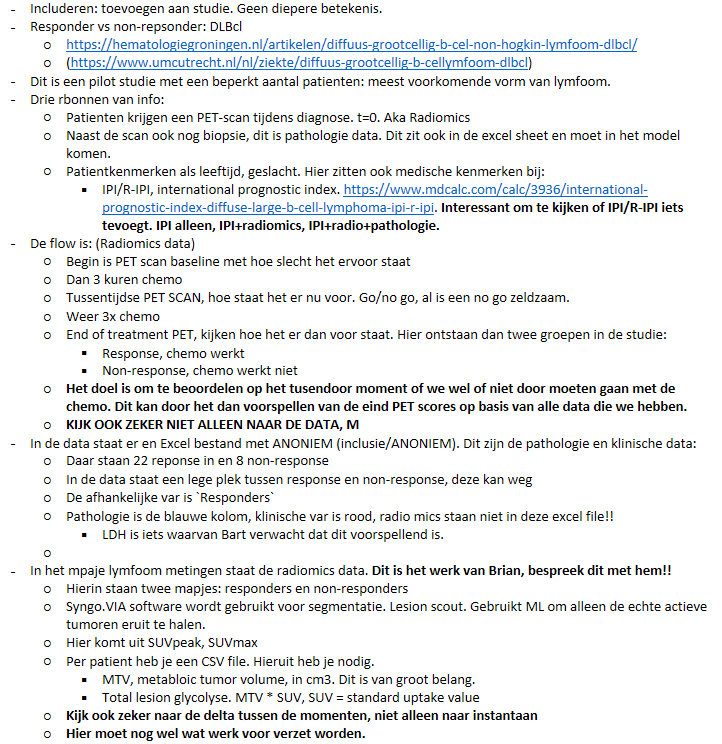

Ik ga eerst de niet-radiomics data klaar zetten voor de studenten, dit zit in het `Inclusie Radiomics studie DLBCL - V2 - ANONIEM.xlsx` bestandje. Let op dat ik voor de studenten alvast de lege regels tussen responders en non-responders al weggehaald heb (rij 25-31). Het resulterende bestandje heet `database_lymfoma_non_radiomics.xlsx`. 

In [ ]:
import pandas as pd

# read excel file and convert to dataframe
df = pd.read_excel('database_lymfoma_non_radiomics.xlsx')
df.head(1)

In [ ]:
df.tail()

Ziet er zo op eerste orde goed uit, studenten kunnen dit verder verwerken. Nu moeten we een leesfunctie en een loader schrijven:

In [ ]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py', local_file="data_loading_functions.py")
data_loading_module.get_lymfoma_non_radiomics().head(1)

# 26-04-2023
Ik heb aan de functie `get_vicodin_data` een betere foutverwerking toegevoegd. Wat er wel eens misgaat is dat de SFTP server aangeeft dat een file niet bestaat. Het is dan soms lastig te bepalen wat er precies misgaat. Een key stuk info is om te kijken welke bestanden er beschikbaar zijn voor de huidige gebruiker. Ik zat er eerst aan te denken om een list_files boolean toe te voegen die als True een lijst produceert met de beschikbare bestanden. 

Ik ben uiteindelijk op een ander alternatief uitgekomen: een try/except die in het geval van een error aangeeft dat het bestand niet bestaat op de server, en een lijst geeft met de bestanden die wel beschikbaar zijn. Het voordeel van deze aanpak is dat de interface van de `get_vicodin_data` niet nodeloos groter wordt, en je krijgt in de context waarin het relevant is direct de foutmeling zonder dat je de code opnieuw hoeft te draaien met `list_files=True`. Ook elimineert het de enorme foutmelding waar studenten niet echt veel aan hebben en geeft veel nuttigere output. 

Ik gebruik nu nog een simpel print statement voor de message, maar zit te denken aan het gebruiken van de logging library. Dit geeft wat meer opties om later flexibel met de log messages om te gaan, bv zowel loggen op scherm als in een file, en kiezen welke niveau van logging je wil zien (DEBUG, INFO, ERROR, etc). 

De volgende code laat die nieuw foutmelding zien:

In [13]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py', local_file="data_loading_functions.py")
data_loading_module.get_non_existing_data()

ERROR:root:Could not find file non_existing_file.xlsx on the server. The following files are available:
 - scripts
 - dgbcl.txt
 - database_lymfoma_non_radiomics.xlsx


Ik heb ook het decrypten van de excel bytestream in een eigen functie gestopt, dit zodat het herbruikbaar is voor andere get functies die een excel moeten decrypten. 

Ik zorg ervoor dat ik de env file voor PSMA gebruik, en de kernel reset:

In [ ]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py', local_file="data_loading_functions.py")
data_loading_module.get_psma_file().head(1)

Dit werkt!~

### Naar meer functionele stijl
De daadwerkelijk loading functions bestaan nu veel uit het aanroepen van `get_vicodin_data` plus wat helper functies. Door dit in een standaard setup te doen met:

    def bla():
        code

Zorgt dit dat de code veel ruimte gebruikt en boilerplate heeft. Het idee gaat zijn dat we een combinatie van currying en composition gebruiken. De functie:

In [ ]:
def psma_loader(bytes_io):
    '''
    Decrypts the BytesIO stream containing the PSMA data and returns a pandas dataframe
    '''
    decrypted = decrypt_excel_bytes(bytes_io, password="xxxxx")
    return pd.read_excel(decrypted, sheet_name='Data', nrows=60, skiprows=1)

Wordt dan iets als

In [ ]:
compose(curry(decrypt_excel_bytes, password="xxxxxxx"),
        curry(pd.read_excel, sheet_name='Data', nrows=60, skiprows=1))

Dus met compose rijg je meerdere functies aan elkaar, met curry stel je de individuele functies goed in. 

Het `functools` package biedt functioneel programmeren implementaties:

In [5]:
from functools import partial, compose

ImportError: cannot import name 'compose' from 'functools' (/opt/conda/lib/python3.9/functools.py)

Hier lopen we tegen het issue aan dat functools geen function composition implementatie heeft, en dat dit [ook niet gaat komen](https://bugs.python.org/issue1506122). [Dit github repo](https://github.com/sfermigier/awesome-functional-python) heeft veel informatie over functioneel programmeren, en laat zien dat het [toolz package](https://github.com/pytoolz/toolz) een populair optie is die dit wel heeft. 

We hebben hier een keuze te maken: gaan we voor een extern pacakge die de functies heeft of gebruiken we het ingebouwde functools en schrijven [we zelf een compose](https://www.geeksforgeeks.org/function-composition-in-python/). Voor backwards compatibility en het feit dat we maar weinig code nodig hebben kies ik ervoor om functools te gebruiken. 

De compose heb ik [hier vandaan](https://www.geeksforgeeks.org/function-composition-in-python/):

In [16]:
from functools import partial, reduce

def compose(*func):
    '''
    Based on the composite_function from https://www.geeksforgeeks.org/function-composition-in-python/
    '''
    def compose_helper(f, g):  
        return lambda x : g(f(x)) # Swapped f and g to change the order of execution of the list of functions in *func
    return reduce(compose_helper, func, lambda x : x)

def a(x):
    print('a')

def b(x):
    print('b')

def c(x):
    print('c')

compose(a,b,c)('a')

a
b
c


Met deze tools kunnen we PSMA herschrijven:

In [ ]:
from functools import partial, reduce

def compose(*func):
    '''
    Based on the composite_function from https://www.geeksforgeeks.org/function-composition-in-python/
    '''
    def compose_helper(f, g):  
        return lambda x : g(f(x)) # Swapped f and g to change the order of execution of the list of functions in *func
    return reduce(compose_helper, func, lambda x : x)

def psma_loader(bytes_io):
    '''
    Decrypts the BytesIO stream containing the PSMA data and returns a pandas dataframe
    '''
    decrypted = decrypt_excel_bytes(bytes_io, password="PSMAsept2022")
    return pd.read_excel(decrypted, sheet_name='Data', nrows=60, skiprows=1)

def get_psma_file():
    '''The function you can use to get the psma data
    
    The only requirement is to have a valid username and password stored in the .env file
    '''
    return get_vicodin_data('database_psma_met_functies.xlsm', loader_function=psma_loader)

psma_loader = compose(partial(decrypt_excel_bytes, password="xxxxxx"),
                      partial(pd.read_excel, sheet_name='Data', nrows=60, skiprows=1))
get_psma_file = partial(get_vicodin_data, 'database_psma_met_functies.xlsm', loader_function=psma_loader)

In [ ]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py', local_file="data_loading_functions.py")
data_loading_module.get_psma_file().head(1)

De code werkt! En het beslaat nog maar de helft van het aantal regels code. We betalen wel een beetje de prijs dat voor mensen die compose en partial niet kennen dat dit wat lastiger leesbaar is. Maar dit moet goed uitgelegd worden in het ontwerp. 

Nu werken we ook de andere getters en loaders om:

In [ ]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py', local_file="data_loading_functions.py")
data_loading_module.get_test_file()

# 11-05-2023: Testing
We gaan vandaag kijken naar het implementeren van een test suite. Deels is dit om in de documentatie de student voor te doen hoe je tests kan maken die onderdeel zijn van je ontwerpprocces. Deels is het natuurlijk om te testen of de tool ook daadwerkelijk doet wat hij moet doen. 

De uitgangspunten zijn:
- De tests zijn niet primair technisch, maar testen functionaliteit. Doet het systeem wat we met elkaar afgesproken hebben. Kan zijn dat hier ook tests onder vallen die niet direct raken aan zaken die de gebruiker kan zien, maar wellicht dat dit dan een stap later wel het geval is. 

### AC1: student kan alleen data inlezen waar hij/zij toegang toe heeft
Dit is natuurlijk één van de meeste essentiele dingen om te checken. Een student moet alleen toegang hebben tot de zaken waar ze doelbinding voor hebben. Hoe we dat afdekken in deze tool is via de SFTP inlog, welke weer gekoppeld is aan de `.env` file die de student in de werkdir heeft staan. 

We kunnen een aantal uitspraken doen voor mensen die een PSMA account hebben:

- Met het PSMA account zou je bij de PSMA data moeten kunnen
- Met het PSMA account zou je *niet* bij de Lymfoma data moeten kunnen
- Met een PSMA account moet je de dataloading module kunnen laden
- Met een PSMA account moet je de test set kunnen inladen

Bovenstaande opties gelden eigenlijk voor alle accounts die actief zijn in het systeem (en geconfigureerd staan in de SFTP server). 

In [1]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py', local_file="data_loading_functions.py")
test = data_loading_module.get_test_file()

# python unittest check if the returned object is a dataframe
import pandas as pd
isinstance(test, pd.DataFrame)

Ik heb net de eerste test gemaakt: kijken of ik de test data kan inladen, en of het een pandas dataframe teruggeeft. De naam van de test is `test_test_data` in de `TestPSMAaccount` set aan tests. Ik maak testscases per account met het idee dat ik straks code kan delen tussen de verschillende test accounts, bijvoorbeeld het inladen van de test data is exact gelijk voor alle accounts. 

Een aantal keuzes die ik maak:
- Ik laad `dataloading_functions.py` lokaal in. Dit sluit wat mij betreft beter aan bij de workflow, je draait de tests als je aan het sleutelen bent aan de code. Anders moet je elke keer dataloadingfunctions uploaden naar de server voordat je de test kan draaien. Het nadeel is natuurlijk dat dit dus niet test of het ook allemaal werkt met de code op de server. Wellicht een optie inbouwen om hierin te kiezen? 
- Ik check alleen of er een dataframe terugkomt als ik de test_data inlees. Eventueel zou ik hier nog kunnen checken of de exacte data gelijk is. 

Volgende stap is om de daadwerkelijk data in te laden. Voor de PSMA case zou ik geen valide DataFrame moeten krijgen als ik Lymfoma lees, maar wel als ik PSMA data lees. 

In [4]:
data_loading_module = get_vicodin_module('scripts/data_loading_functions.py', local_file="data_loading_functions.py")
lymfoma_data = data_loading_module.get_lymfoma_non_radiomics()

ERROR:root:Could not find file database_lymfoma_non_radiomics.xlsx on the server. The following files are available:
 - scripts
 - database_psma_met_functies.xlsm
 - psma.txt


# 09-06-2023: meer testen
Dit is het eerste werk wat ik aan de SFTP tool doe sinds het zijn eigen repo heeft gekregen. Als je de bestaande test wil draaien kun je dit door **in de terminal van de container** uit te voeren:

    python tests.py

Een issue was nog dat bij de test die kijkt of je een bepaald bestand *niet* kan inlezen dat er een error message in beeld kwam. Deze message heb ik nu optioneel gemaakt via `silent_fail`. Als deze op `True` staat wordt de boodschap niet geprint. 

# 22-09-2023: Gevoelige informatie uitsplitsen
We zijn van plan om de tool open-source te maken, maar dan moet je natuurlijk wel ervoor zorgen dat alle gevoelige informatie niet in het repo beschikbaar is. Deels hebben we dit op opgelost door de sftp_tool af te splitsen van het psma project waar het eerste onderdeel van was. Maar de get functies die we per project maken bevatten nog wel gevoelige informatie zoals excel passwords. Het idee is om dit op te lossen door de file niet langer onderdeel te maken van het repo. Het algemene deel van `data_loading_functions` blijft, maar het project specifieke moet buiten het git repo komen te liggen. 

Hoe we dit gaan doen is een beetje vergelijkbaar met hoe we met de sftp credentials omgaan, het komt in een losse file te staan die je als configuratie toevoegt. Wat zou kunnen is dat `data_loading_functions.py` checkt of er source file bestaat met een voorafgesproken naam, bv `local_getters.py`. Alle loaders en getters die daar staan worden dan automatisch ingelezen from `from xxx import *`. Deze file bevat dan de gevoelige informatie, maar is niet onderdeel van het open-source repo. We kunnen dan een prive repo hebben waar deze gevoelige config informatie in staat. En nieuwe gebruikers kunnen hun eigen gevoelige getters en loaders schrijven. 

Een uitdaging is hier om de local_getters goed in data_loading functions te integreren, twee opties:
- Maak ook binnen data_loading_functions gebruik van `make_module` zoals in module_loading_functions. Overwegingen: 
  - dat je er dan voor moet zorgen dat bij het lezen van de code deze ook weer voor module_loading_functions beschikbaar komt. 
  - het is de vraag of de functies als `get_vicodin_data` uit de main env dan beschikbaar zijn binnen de door `make_module` aangemaakte module op basis van `local_getters` (net gekeken, dit werkt wel)
  - voordeel zou zijn dat je wel makkelijk de naam `local_getters` kan aanpassen

- gebruik `from local_getters import *`. 
  - nadeel hier is dat er over en weer afhankelijkheden zijn, `local_getters` heeft een aantal basis functies uit `data_loading_functions` nodig, en `data_loading_functions` importeert dan `local_getters` weer. Over het algemeen zijn dit soort [circulaire imports](https://stackabuse.com/python-circular-imports/) niet een goed idee. 


Toen ik besefte dat via make_module ik eigenlijk ook een circulaire dependcy maakte heb ik beslist om simpelweg `from bla import *` te gebruiken. Hoef ik `make_module` niet te herhalen in `data_load_functions`, en het mechanisme sluit beter aan bij wat gebruikers al kennen. 

Denk erom dat ik natuurlijk eerst kijk of de `local_getter.py` file wel echt bestaat. Dit doe ik met pathlib, dat is de huidige beste methode schijnt. 

In [ ]:
from module_loading_functions import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/data_loading_functions.py', local_file="data_loading_functions.py")
data_loading_module.get_psma_file().head(1)

Uiteindelijk was het vrij straightforward: 
- Kopieer alle getters en loaders naar `local_getters.py`
- importeer, als de file bestaat, `from local_getters import *`
- zorg ervoor dat je alle relevante imports doet in `local_getters.py`, deels zaken van standaard python libraries, deels uit `data_loading_functions.py`. Dit creeert een circulaire dependency, en dus moet `data_loading_functions.py` **altijd** samen met `local_getters.py` worden gedeployed. Dat moet sowieso al, dus dat valt mee. De circulaire dependency voelt niet direct als een super elegante oplossing, maar het werkt voor nu. 

# 22-11-2023: op naar een Python package
Bleek dat het werken met een local_getter.py niet werkte zoals ik verwacht had. Het issue is dat als ik de local_getters file op de sftp server klaar zet dat deze niet noodzakelijkerwijs ingelezen wordt. Doordat ik data_loading_functions lokaal download wordt zodra de import 'from local_getters import \*' gedaan wordt probeert Python dit *lokaal* in te lezen, niet vanaf de server. Ik zou dit kunnen oplossen door twee bestandjes te downloaden, maar dat wordt wel een beetje hackerig. 

Een meer cleane oplossing is alle code in een python package te verwerken die de student dan lokaal installeert. Het systeem download dan een scriptje, in principe `local_getters.py`, die de functie levert om de data op te halen. Deze functie maakt dan gebruik van het lokaal geinstalleerde pacakge voor de relevante functies. Stel dat het python package `sftp_data_provider` heet, dan zou de workflow zoiets worden als:

In [ ]:
# Dit is in een notebook
from sftp_data_provider import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/project_loading_functions.py') # dit is dan wat nu local_getters is
data_loading_module.get_project_data().head(1)

Binnen `project_loading_functions`:

In [ ]:
# dit is in het python script wat van de server gedownload wordt
from sftp_data_provider import get_vicodin_data
import pandas as pd

def get_project_data():
    return get_vicodin_data("project_data.xlsx", pd.read_excel)

Het notebook staat lokaal voor de gebruiker, en het script `project_loading_functions` wordt ook lokaal gedownload. Dus beide kunnen dan gebruik maken van de lokaal geinstalleerde code in het `sftp_data_provider` package. 

Het gebruiken van een package heeft een aantal voordelen:
- We kunnen het uploaden naar een package repo, dan wordt het makkelijk te installeren via `pip install sftp_data_provider`. 
- We kunnen dependencies via pip managen. 
- Het wordt makkelijker voor andere mensen om op ons werk voort te bouwen. 

Het maken van een package was vrij simpel, ik volg de aanwijzingen [in deze link](https://packaging.python.org/en/latest/tutorials/packaging-projects/). 

Denk om:
- De lokale versie moet up-to-date zijn met de zaken die in het script gebruikt worden. Het zou anders kunnen voorkomen dat een functie die je gebruikt niet in de lokale versie van sftp_data_provider zit. Ik denk dat een studentgroep dit package vers installeert, dus denk niet dat dit een al te groot issue gaat worden. 

### Testen
Om te kunnen testen of dit werkt moet het geintegreerd worden in het bouwen van de container die ik voor testen gebruik. Kunnen we direct ook zien of het goed werkt in een cleane environment. Hiervoor gaan we de dockerfile aanpassen om:
- De gebouwde tar.gz file van het package naar de container te sturen
- Het pacakge te installeren

Let op dat ik de Dockerfile naar de hoofddirectory van het repo gedaan heb. [Dit omdat standaard Docker alleen files naar de container kan kopieren tijdens het *bouwen* van de container die in de direcotry staan waar de Dockerfile in staat](https://stackoverflow.com/questions/27068596/how-to-include-files-outside-of-dockers-build-context). De makkelijkste oplossing voor nu is om de Dockerfile simpelweg in de root van het repo te zetten. 

Ook heb ik voor nu de verwijzing naar de file inclusief versie gemaakt. Dus als je een nieuwe versie bouwt van het package moet je hier ook deze versie aanpassen in de Dockerfile. Dit is voornamelijk handig voor even lokaal testen of het allemaal werkt. 

Alles werkte nu goed in de container, dus dit zou nu moeten werken:

In [3]:
from sftp_data_provider import get_vicodin_module

data_loading_module = get_vicodin_module('scripts/psma_getters.py') # dit is dan wat nu local_getters is
data_loading_module.get_project_data()

,Patient ID,SUVmax primaire tumor,SUVmean aorta,cT-stage,Type,Locatie van aankleuring,SUVmax van aankleuring,Referentie SUVmax van aankleuring,Aantal hotspots lymfeklieren,Aantal hotspots bot,Classificatie
0,0,34.04,2.11,cT2,Bot,Bekken,8.13,1.70,4,1,0
1,0,34.04,2.11,cT2,Lymfeklier,Pelvic lymph node,5.26,1.77,4,1,1
2,0,34.04,2.11,cT2,Lymfeklier,Pelvic lymph node,10.83,1.77,4,1,1
3,0,34.04,2.11,cT2,Lymfeklier,Pelvic lymph node,5.59,1.77,4,1,1
4,0,34.04,2.11,cT2,Lymfeklier,Pelvic lymph node,11.17,1.77,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...
556,108,21.21,1.25,cT4,Lymfeklier,Pelvic lymph node,14.04,1.02,6,8,1
557,108,21.21,1.25,cT4,Lymfeklier,Pelvic lymph node,11.55,1.02,6,8,1
558,108,21.21,1.25,cT4,Lymfeklier,Pelvic lymph node,17.42,1.02,6,8,1
559,108,21.21,1.25,cT4,Lymfeklier,Communis (iliaca),15.39,1.02,6,8,1


Wat ik me nog bedacht, voor dit soort erg simpele getters hoe je in principe niet eens een getter_script klaar te zetten wat je ophaalt met `get_vicodin_module`. Je kunt dan ineens get_vicodin_data aanroepen:

In [6]:
from sftp_data_provider import get_vicodin_data
import pandas as pd

get_vicodin_data("psma_data_verwerkt.xlsx", pd.read_excel)

,Patient ID,SUVmax primaire tumor,SUVmean aorta,cT-stage,Type,Locatie van aankleuring,SUVmax van aankleuring,Referentie SUVmax van aankleuring,Aantal hotspots lymfeklieren,Aantal hotspots bot,Classificatie
0,0,34.04,2.11,cT2,Bot,Bekken,8.13,1.70,4,1,0
1,0,34.04,2.11,cT2,Lymfeklier,Pelvic lymph node,5.26,1.77,4,1,1
2,0,34.04,2.11,cT2,Lymfeklier,Pelvic lymph node,10.83,1.77,4,1,1
3,0,34.04,2.11,cT2,Lymfeklier,Pelvic lymph node,5.59,1.77,4,1,1
4,0,34.04,2.11,cT2,Lymfeklier,Pelvic lymph node,11.17,1.77,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...
556,108,21.21,1.25,cT4,Lymfeklier,Pelvic lymph node,14.04,1.02,6,8,1
557,108,21.21,1.25,cT4,Lymfeklier,Pelvic lymph node,11.55,1.02,6,8,1
558,108,21.21,1.25,cT4,Lymfeklier,Pelvic lymph node,17.42,1.02,6,8,1
559,108,21.21,1.25,cT4,Lymfeklier,Communis (iliaca),15.39,1.02,6,8,1


import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph LR;
    A--> B & C & D;
    B--> A & E;
    C--> A & E;
    D--> A & E;
    E--> B & C & D;
""")

In [1]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph LR;
    A--> B & C & D;
    B--> A & E;
    C--> A & E;
    D--> A & E;
    E--> B & C & D;
""")